In [36]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import os
import src.model_registry
from config import ROOT_DIR
from src.utils.video import VideoHandler
import cv2
from roboflow import Roboflow
from src.utils.geometry import *
from src.utils.user_input import get_coordinate_input
from ultralytics import YOLO
from ultralytics.data.augment import LetterBox
from pathlib import Path, PosixPath
import torch
from contextlib import contextmanager
import pathlib
import matplotlib.pyplot as plt
from src.utils.drawing import draw_rect, plot_images
import io

In [20]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


### Grab Frame for processing
Grabbing a frame from Main Street and Cotton since that one has a lot
of vehicle instances that are similar, and hence will be a good test for
the ENMS algorihm

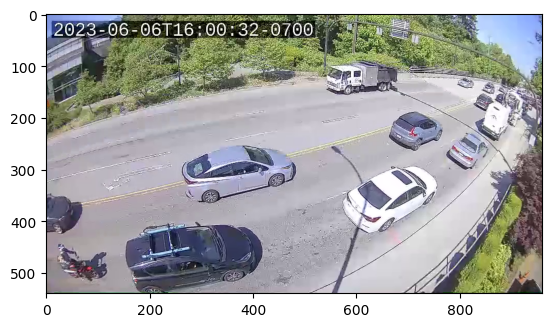

In [17]:
video_handler = VideoHandler(str(ROOT_DIR / "accuracy_testing/Main_St_and_Cotton_Rd_4-5_accuracy_testing.mp4"))
first_frame = video_handler.get_frame(1000) # this frame has a lot of vehicles
plt.imshow(cv.cvtColor(first_frame, cv.COLOR_BGR2RGB))

### Run object detection
run yolov8 on the image to get Detection objects that we can use for ENMS

{0: 'bus', 1: 'const', 2: 'lt', 3: 'o', 4: 'rvc', 5: 'sv', 6: 'trcont', 7: 'trflat', 8: 'tronly', 9: 'trreefer', 10: 'trtank', 11: 'trtrail', 12: 'vp', 13: 'waste'}



0: 384x640 2 lts, 9 svs, 1 vp, 63.9ms
Speed: 3.0ms preprocess, 63.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


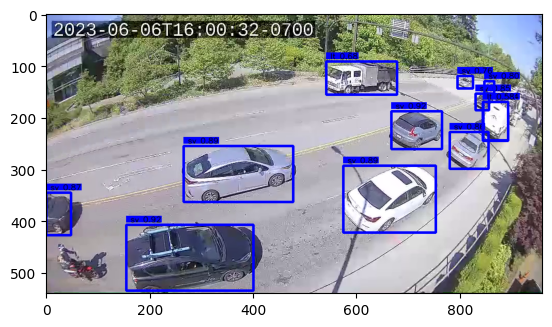

In [137]:
detector_selector = src.model_registry.ModelRegistry(str(ROOT_DIR / "models/detection"))
detector = detector_selector.generate_model("test_yolov8l")
print(detector.get_classes())
detections = detector.inference(first_frame, device=device, conf=0.5, iou=0.45)

# drawing results
img = first_frame.copy()
for det in detections:
    bbox = points_to_rect(det.points)
    # filter small bboxes out (maybe?)
    draw_rect(
        img=img,
        rect=bbox,
        class_name=detector.get_classes().get(det.data.get("class")),
        conf=det.data.get("conf")
    )

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

### Slice detections into separate single object images

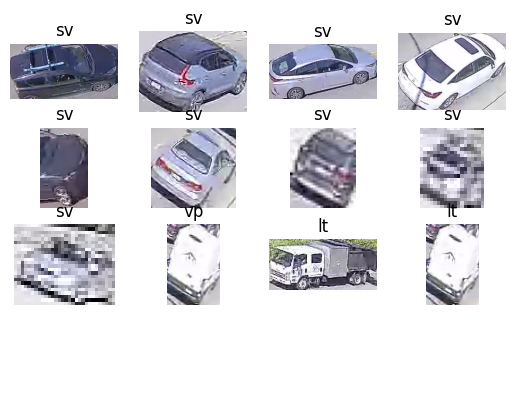

In [139]:
img_list = []
titles = []
for idx, det in enumerate(detections):
    # slice out single object from image, making sure to clip coords
    # outside of the image boundaries
    bbox = points_to_rect(det.points).to_int()
    bbox.clip(first_frame.shape[1], first_frame.shape[0])
    x1, y1 = bbox.top_left.as_tuple()
    x2, y2 = bbox.bottom_right.as_tuple()
    img_slice = first_frame[y1:y2, x1:x2]
    img_list.append(cv.cvtColor(img_slice, cv.COLOR_BGR2RGB))
    titles.append(detector.get_classes().get(det.data.get("class")))

# display sliced images
plot_images(img_list, titles)

### Compute the vector embeddings of each sliced image;
1. load CLIP model
2. compute image vector embeddings
3. compute cosine similarity matrix

In [ ]:
# Load the OpenAI CLIP Model
print("Loading CLIP Model...")
model = SentenceTransformer("clip-ViT-B-32")

In [133]:
# Next we compute the embeddings
encoded_images = model.encode(
    [Image.fromarray(img) for img in img_list], # sentence transformers requires PIL image I guess
    batch_size=16,
    convert_to_tensor=True,
    show_progress_bar=True,
)
print(encoded_images)

# # Now we run the clustering algorithm. This function compares images aganist
# # all other images and returns a list with the pairs that have the highest
# # cosine similarity score
processed_images = util.paraphrase_mining_embeddings(encoded_images)
print(processed_images) # for seeing how each image compares to each other

Batches: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


tensor([[ 0.6009,  0.5659,  0.2382,  ...,  0.8515, -0.1625, -0.0186],
        [ 0.4655,  0.4080,  0.1012,  ...,  0.6178, -0.2411,  0.1003],
        [ 0.4603,  0.4987,  0.2615,  ...,  0.4881, -0.1049,  0.0072],
        ...,
        [ 0.2143,  0.0770, -0.4017,  ...,  1.0041,  0.2331,  0.0292],
        [ 0.4425,  0.1337,  0.0935,  ...,  1.0596,  0.0069,  0.0781],
        [ 0.3216,  0.0877, -0.4118,  ...,  0.8923,  0.2525, -0.1353]], device='cuda:0')
[[0.9713398218154907, 9, 11], [0.9405756592750549, 7, 8], [0.9346416592597961, 6, 8], [0.9326457977294922, 0, 4], [0.919161856174469, 1, 5], [0.9091238975524902, 0, 3], [0.906177282333374, 6, 7], [0.8973977565765381, 0, 2], [0.8925600051879883, 1, 2], [0.8752867579460144, 2, 4], [0.8725372552871704, 3, 5], [0.8718270063400269, 0, 1], [0.8660879731178284, 2, 3], [0.863466203212738, 1, 3], [0.8621520400047302, 2, 5], [0.8597934246063232, 3, 4], [0.8569785952568054, 7, 9], [0.8483765125274658, 4, 11], [0.8476197123527527, 7, 11], [0.8448540568351

In [134]:
cos_scores = util.cos_sim(encoded_images, encoded_images)
print(cos_scores)

tensor([[1.0000, 0.8718, 0.8974, 0.9091, 0.9326, 0.8400, 0.6216, 0.6364, 0.6066, 0.6497, 0.8129, 0.7511],
        [0.8718, 1.0000, 0.8926, 0.8635, 0.8449, 0.9192, 0.6277, 0.5968, 0.6008, 0.5796, 0.8039, 0.6799],
        [0.8974, 0.8926, 1.0000, 0.8661, 0.8753, 0.8622, 0.5840, 0.5936, 0.5673, 0.6110, 0.7802, 0.6997],
        [0.9091, 0.8635, 0.8661, 1.0000, 0.8598, 0.8725, 0.5850, 0.5709, 0.5644, 0.5748, 0.7438, 0.6662],
        [0.9326, 0.8449, 0.8753, 0.8598, 1.0000, 0.8265, 0.6745, 0.7313, 0.6884, 0.7574, 0.8277, 0.8484],
        [0.8400, 0.9192, 0.8622, 0.8725, 0.8265, 1.0000, 0.6720, 0.6277, 0.6367, 0.6207, 0.7995, 0.7010],
        [0.6216, 0.6277, 0.5840, 0.5850, 0.6745, 0.6720, 1.0000, 0.9062, 0.9346, 0.7526, 0.7152, 0.7535],
        [0.6364, 0.5968, 0.5936, 0.5709, 0.7313, 0.6277, 0.9062, 1.0000, 0.9406, 0.8570, 0.7015, 0.8476],
        [0.6066, 0.6008, 0.5673, 0.5644, 0.6884, 0.6367, 0.9346, 0.9406, 1.0000, 0.7934, 0.7089, 0.7907],
        [0.6497, 0.5796, 0.6110, 0.5748, 0.757

### ENMS algorithm for finding image-level entropy

In [150]:
# assume we have these as input into the function
classes = [det.data.get("class") for det in detections]
confidences = [det.data.get("conf") for det in detections]
thresh = 0.8 # changes how small the angle can get between two feature vectors
# NOTE: the embeddings will come in the tensor form above, where each row is
# the embedding for an instance

In [156]:
E_total = 0
E_instances = np.array([-conf * np.log2(conf) - (1 - conf) * np.log2(1 - conf) for conf in confidences])
indicating_set = list(range(len(E_instances)))

while indicating_set:
    idx = np.argmax(E_instances[indicating_set])
    most_informative_inst = indicating_set[idx]
    indicating_set.pop(idx)
    E_total += E_instances[most_informative_inst]
    for inst in indicating_set[:]:
        if classes[inst] == classes[most_informative_inst] and cos_scores[inst, most_informative_inst].item() > thresh:
            # instances are redundant, get rid of lower information one
            indicating_set.remove(inst)

### Lets put that into a function

In [191]:
def ENMS(
    classes: List[int],
    confidences: List[float],
    features: torch.tensor,
    similarity_thresh: float = 0.5,
) -> float:
    """computes the image-level entropy as a means of describing the information
    content in the image (and subsequently how useful it will be to train on)

    The algorithm is from https://arxiv.org/abs/2204.07965. It performs entropy-
    based Non-Maxium Suppression in order to find a better representation of the
    information content contained in the image, taking into account instance-level
    redundancy.

    Arguments
    ---------
    classes (List[int]):
        classes corresponding to detected objects in the image
    confidences (List[float]):
        confidences for the detected objects
    features (torch.tensor):
        a len(classes) x n feature matrix where the ith row
        corresponds to the feature vector of the ith instance detected
    similarity_thresh (float):
        the threshold used for filtering similar instances. Any instances
        of the same class with a similarity score above this threshold will be
        filtered out

    Returns
    -------
    float:
        the image-level entropy
    """

    cos_scores = util.cos_sim(features, features)

    E_total = 0
    E_instances = np.array(
        [-conf * np.log2(conf) - (1 - conf) * np.log2(1 - conf) for conf in confidences]
    )
    indicating_set = list(range(len(E_instances)))

    while indicating_set:
        idx = np.argmax(E_instances[indicating_set])
        most_informative_inst = indicating_set[idx]
        indicating_set.pop(idx)
        E_total += E_instances[most_informative_inst]
        for inst in indicating_set[:]:
            if (
                classes[inst] == classes[most_informative_inst]
                and cos_scores[inst, most_informative_inst].item() > similarity_thresh
            ):
                # instances are redundant, get rid of lower information one
                indicating_set.remove(inst)

    return E_total

## Diverse Prototype Algorithm for inter-image diversity
- we build a prototype of each class per image that is basically just
a weighted sum of the feature vectors for every instance of that class in the image
- instances with high classification confidence scores contribute less to the prototype
than uncertain ones

**Note:** We assume no access to the data set, so the diverse proto algorithm
will be a bit scuffed I think. They use the total labeled dataset class counts
for ensuring interclass balancing, we are gonna have to rely on the user specifying
classes not to capture for active learning
- or we integrate with roboflow but idk how I feel about tying this in directly
with it

### We first need to extract multiple frames now

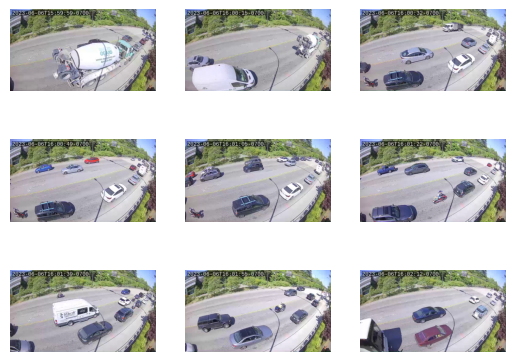

In [164]:
frames = []
for i in range(0, video_handler.frame_count, 500):
    frames.append(cv.cvtColor(video_handler.get_frame(i), cv.COLOR_BGR2RGB))
plot_images(frames)

### Run inference on all the frames

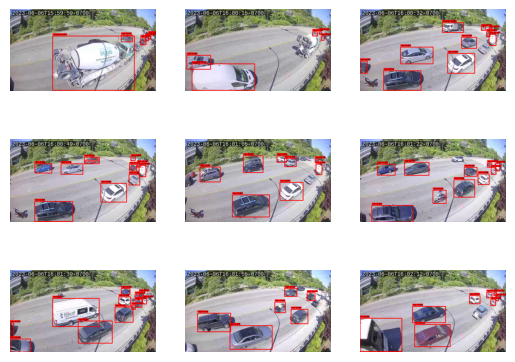

In [166]:
detections = []
images = []
for idx, frame in enumerate(frames):
    detections.append(detector.inference(frame, verbose=False, device=device, conf=0.5, iou=0.45))

    # draw results
    img = frame.copy()
    for det in detections[idx]:
        bbox = points_to_rect(det.points)
        # filter small bboxes out (maybe?)
        draw_rect(
            img=img,
            rect=bbox,
            class_name=detector.get_classes().get(det.data.get("class")),
            conf=det.data.get("conf")
        )

    images.append(img)

plot_images(images)

### Extract single object images

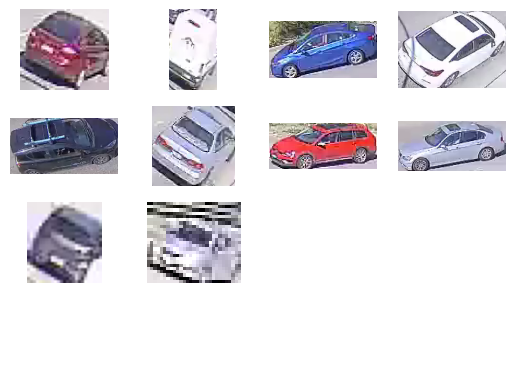

In [187]:
# we now have to deal with list of lists
total_img_list = []
for idx, det_list in enumerate(detections):
    img_list = []
    for det in det_list:
        # slice out single object from image, making sure to clip coords
        # outside of the image boundaries
        img = det.data.get("img")
        bbox = points_to_rect(det.points).to_int()
        bbox.clip(img.shape[1], img.shape[0])
        x1, y1 = bbox.top_left.as_tuple()
        x2, y2 = bbox.bottom_right.as_tuple()
        img_slice = img[y1:y2, x1:x2]
        img_list.append(img_slice)
    total_img_list.append(img_list)

# show some detected vehicles
plot_images(total_img_list[3])

### Now time for active learning
We have our image predictions, so we can now run the active learning algorithms

In [195]:
embeddings_list = []
for img_list in total_img_list:
    # compute embeddings
    embeddings = model.encode(
        [Image.fromarray(img) for img in img_list], # sentence transformers requires PIL image I guess
        batch_size=16,
        convert_to_tensor=True,
        show_progress_bar=True,
    )
    embeddings_list.append(embeddings)

# input for the ENMS function
classes = [np.array([det.data.get("class") for det in det_list]) for det_list in detections]
confidences = [np.array([det.data.get("conf") for det in det_list]) for det_list in detections]
thresh = 0.8 # changes how small the angle can get between two feature vectors

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


**Note:** we can probably compute the quota for minor classes just based on the
classes the user specified and some fixed parameters

In [ ]:
budget = 4 # total images we can take (there are 9 in total)
T_intra = 0.7
T_inter = 0.3

"""
TODO:
1. calculate protype per unique class in each image
2. calculate minority class quotas somehow
3. sort candidate images based on entropy (descending order)
4. for loop with all hard calcs
"""

selected_images = []
candidate_images = []
for idx, det_list in enumerate(detections):
    entropy = ENMS(classes[idx], confidences[idx], embeddings_list[idx], thresh=thresh)
    # TODO: calculate prototype per unique class in this image
    
